In [101]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv as inv
from neuron_decoding import *
import pickle
from sklearn.metrics import r2_score


fn = 'raw_data/loco_20170302_02.mat'
# 加载.mat文件
with h5py.File(fn, 'r') as file:
    finger_pos = file['finger_pos'][:]
    finger_pos = np.array(finger_pos).transpose()
    cursor_pos = file['cursor_pos'][:]
    cursor_pos = np.array(cursor_pos).transpose()
    t = file['t'][:]
    t = np.array(t).transpose()
    print(finger_pos.shape)
    print(t.shape)
    spike_times = []
    for column in file['spikes']:
        column_data = []
        for row_number in range(len(column)):
            row_data = np.array(file[column[row_number]])
            column_data.append(row_data)
        spike_times.append(column_data)
    spike_times = np.array(spike_times,dtype='object').transpose()
    spike_times = spike_times[:,1:5]
    print(spike_times.shape)
    spike_times = spike_times.reshape(-1,1)
    # spike_times = np.array([x for x in spike_times if len(x) >= 1000])
    # print(spike_times.shape)

    spike_times=np.squeeze(spike_times)
    for i in range(spike_times.shape[0]):
        spike_times[i]=np.squeeze(spike_times[i])
    print(spike_times.shape)
    spike_times = np.array([x for x in spike_times if x.size >= 1000],dtype='object')

    print(spike_times.shape)


In [102]:
dt=.04 #Size of time bins (in seconds)
t_start=t[0] #Time to start extracting data - here the first time velocity was recorded
t_end=t[-1] #Time to finish extracting data - here the last time velocity was recorded
downsample_factor=1 #Downsampling of output (to make binning go faster). 1 means no downsampling.




###Preprocessing to put spikes and output in bins###

#Bin neural data using "bin_spikes" function
neural_data=bin_spikes(spike_times,dt,t_start,t_end)

#Bin output (velocity) data using "bin_output" function
pos_binned=bin_output(cursor_pos,t,dt,t_start,t_end,downsample_factor)

(11416, 344)


In [103]:
data_folder='' #FOLDER YOU WANT TO SAVE THE DATA TO

with open(data_folder+'data_loco_20170302_02.pickle','wb') as f:
    pickle.dump([neural_data,pos_binned],f)

In [103]:
folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/'

with open(folder+'data_loco_20170302_02.pickle','rb') as f:
    neural_data,pos_binned=pickle.load(f)

In [104]:
lag=0

X_kf=neural_data

#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of velocity (for this dataset)
#But using them all as covariates helps performance

#We will now determine vels
temp = np.diff(pos_binned, axis=0)
vels_binned = np.concatenate((temp, temp[-1:, :]),
                            axis=0)

#We will now determine acceleration
temp = np.diff(vels_binned, axis=0)  #The acceleration is the difference in velocities across time bins
acc_binned = np.concatenate((temp, temp[-1:, :]),
                            axis=0)  #Assume acceleration at last time point is same as 2nd to last

#The final output covariates include position, velocity, and acceleration
y_kf = np.concatenate((pos_binned, vels_binned, acc_binned), axis=1)


num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]



#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 1]

In [105]:
## Split Data: For KF
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]

#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int32(np.round(training_range[0]*num_examples_kf))+1,np.int32(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int32(np.round(testing_range[0]*num_examples_kf))+1,np.int32(np.round(testing_range[1]*num_examples_kf))-1)


#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]


[0, 2]
R2: [-0.159, 0.473]
rho2: [0.125, 0.5]
[2, 4]
R2: [0.187, 0.366]
rho2: [0.21, 0.37]
[4, 6]
R2: [0.018, 0.131]
rho2: [0.043, 0.136]
[0, 4]
R2: [-0.029, 0.547, 0.232, 0.383]
rho2: [0.251, 0.594, 0.252, 0.393]
[0, 6]
R2: [-0.099, 0.536, 0.233, 0.395, 0.021, 0.14]
rho2: [0.225, 0.591, 0.257, 0.403, 0.062, 0.152]


R2: [-0.099, 0.536, 0.233, 0.395, 0.021, 0.14]
rho2: [0.225, 0.591, 0.257, 0.403, 0.062, 0.152]


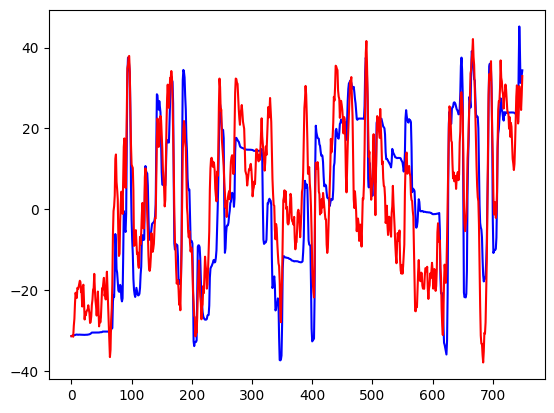

In [110]:
#Z-score inputs
X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)
X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std


#Zero-center outputs
y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
y_kf_test=y_kf_test-y_kf_train_mean


In [107]:
from sklearn.metrics import r2_score
#Declare model
model_kf=KalmanFilterRegression(C=2) #There is one optional parameter that is set to the default in this example (see ReadMe)

#Fit model\
model_kf.fit(X_kf_train,y_kf_train)

#Get predictions
y_test_predicted_kf=model_kf.predict(X_kf_test,y_kf_test)


In [108]:
print(y_test_predicted_kf.shape)

[0.007, 0.275, 0.192, 0.35, 0.019, 0.13]
rho2: [0.085, 0.309, 0.197, 0.351, 0.043, 0.134]


In [109]:

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=[r2_score(y_kf_test[:,i],y_test_predicted_kf[:,i]) for i in range(6)]
print('R2:',R2_kf[0:6]) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_test,y_test_predicted_kf)
print('rho2:',rho_kf[0:6]**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

(7989, 344)
(3423, 6)


In [111]:
fig_x_kf=plt.figure()
i = 3
plt.plot(y_kf_test[1000:2000,i]+y_kf_train_mean[i],'b')
plt.plot(y_test_predicted_kf[1000:2000,i]+y_kf_train_mean[i],'r')

(3423, 6)


In [2]:
from tensorflow import keras


NotFoundError: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): symbol not found in flat namespace '__ZN10tensorflow8internal10LogMessage16VmoduleActivatedEPKci'